# Discriminator Tutorial

The discriminator experiment takes calibration data of different states and fits them to obtain a discriminating classifier that takes kerneled IQ data to state data. First, let's import required libraries:

In [1]:
%load_ext autoreload
%autoreload 2
from qiskit_experiments.library.measurement import TwoLevelDiscriminator
from qiskit_experiments.framework.composite import ParallelExperiment
from qiskit.providers.backend import BackendV1 as Backend
from typing import Tuple
from qiskit.providers.options import Options
from qiskit.qobj.utils import MeasLevel

from qiskit import QuantumCircuit
from qiskit_experiments.test.mock_iq_backend import MockIQBackend

from qiskit_experiments.data_processing.data_processor import DataProcessor
from qiskit_experiments.data_processing.nodes import Probability, TwoLevelDiscriminate

We will run this experiment on a simple mock backend that outputs IQ data in different clusters corresponding to the $|0\rangle$ and $|1\rangle$ states.

In [2]:
class DiscriminatorBackend(MockIQBackend):
    """
    A simple backend that generates gaussian data for discriminator tests
    """

    def __init__(
        self,
        iq_cluster_centers: Tuple[float, float, float, float] = (1.0, 1.0, -1.0, -1.0),
        iq_cluster_width: float = 1.5,
    ):
        """
        Initialize the discriminator backend
        """
        super().__init__(iq_cluster_centers, iq_cluster_width)
        self.configuration().basis_gates = ["x"]

    def _compute_probability(self, circuit: QuantumCircuit) -> float:
        """Returns the probability based on the frequency."""
        if circuit.data[0][0].name == "x":
            return 1
        elif circuit.data[0][0].name == "barrier":
            return 0

## Run Example Discriminator Experiment on One Qubit

Let's run a simple experiment that fits the default LDA classifier.

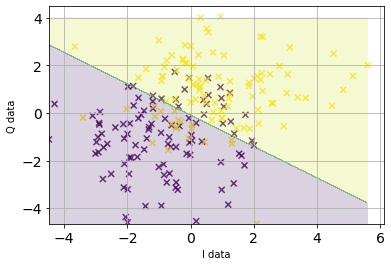

DbAnalysisResultV1
- name: discriminator
- value: LinearDiscriminantAnalysis()
- device_components: ['Q1']
- verified: False


In [3]:
backend = DiscriminatorBackend()
exp = TwoLevelDiscriminator(1)
exp.set_analysis_options(discriminator_type="LDA")
exp_data = exp.run(backend, shots=100)
exp_data.block_for_results()
result = exp_data.analysis_results(0)
display(exp_data.figure(0))
print(result)

QDA classifier on the same data:

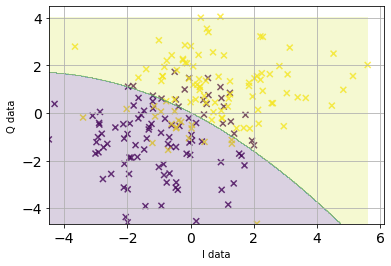

DbAnalysisResultV1
- name: discriminator
- value: QuadraticDiscriminantAnalysis()
- device_components: ['Q1']
- verified: False


In [4]:
backend = DiscriminatorBackend()
exp = TwoLevelDiscriminator(1)
exp.set_analysis_options(discriminator_type="QDA")
exp_data = exp.run(backend, shots=100)
exp_data.block_for_results()
result = exp_data.analysis_results(0)
display(exp_data.figure(0))
print(result)

## Run Discriminator Experiments in Parallel 

Multiple discriminators can be calibrated and analyzed at the same time over different qubits by using the parallel experiments framework. Note that unlike single experiments, parallel experiments need to have `MeasLevel` set to kerneled and `meas_return` set to single so that the data points returned are individual undiscriminated shots. To display the figures for each qubit, `component_experiment_data` is used to access the experiment data of each individual experiment.

In [5]:
from qiskit_experiments.framework.composite import ParallelExperiment

backend = DiscriminatorBackend()
par_exp = ParallelExperiment([TwoLevelDiscriminator(0), TwoLevelDiscriminator(1)])
par_exp.set_run_options(meas_level=MeasLevel.KERNELED, meas_return="single")
par_expdata = par_exp.run(backend, shots=1000)
par_expdata.block_for_results()
print(par_expdata)

---------------------------------------------------
Experiment: ParallelExperiment
Experiment ID: 773ffc0c-73ce-44ef-ab54-bdcb4600a3d2
Status: DONE
Component Experiments: 2
Circuits: 2
Analysis Results: 1
---------------------------------------------------
Last Analysis Result:
DbAnalysisResultV1
- name: parallel_experiment
- value: 2
- extra: <2 items>
- device_components: ['Q0', 'Q1']
- verified: False


Note that the two figures below look identical because the mock backend currently outputs the same seeded random data for each qubit, but if you run the code on a real device, the data will of course be different.

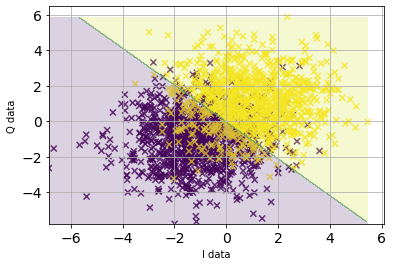

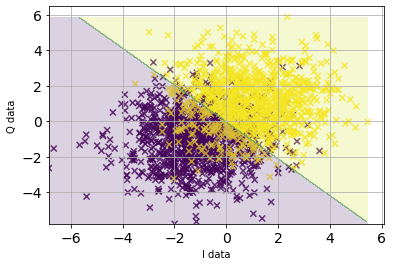

In [6]:
display(par_expdata.component_experiment_data(0).figure(0))
display(par_expdata.component_experiment_data(1).figure(0))

## Use Data Processor Discriminator Node

The discriminator can be used as a node in the data processing framework to take level 1 IQ data to level 2 binary data. Discriminators can be instantiated with calibration data or trained.

In [7]:
backend = DiscriminatorBackend()
exp = TwoLevelDiscriminator(1)
exp.set_analysis_options(discriminator_type="LDA")
exp.set_run_options(meas_level=MeasLevel.KERNELED)
lda_res = exp.run(backend, shots=1024)
processor = DataProcessor("memory", [TwoLevelDiscriminate(lda_res)])
processor.append(Probability("0"))
datum = processor(lda_res.data(0))

backend = DiscriminatorBackend()
exp2 = TwoLevelDiscriminator(1)
exp2.set_analysis_options(discriminator_type="QDA")
exp2.set_run_options(meas_level=MeasLevel.KERNELED)
qda_res = exp2.run(backend, shots=1000)
qda_processor = DataProcessor("memory", [TwoLevelDiscriminate(qda_res)])
qda_processor.append(Probability("0"))
print(qda_res)
datum = qda_processor(qda_res.data(0))

AttributeError: 'TwoLevelDiscriminate' object has no attribute '_handle'

In [ ]:
# LDA node
processor = DataProcessor("memory", [Discriminate(lda_res)])
processor.append(Probability("0"))
datum = processor(lda_res.data(0))
print(datum)

# QDA node
processor = DataProcessor("memory", [Discriminate(qda_res)])
processor.append(Probability("0"))
datum = processor(qda_res.data(0))

print(datum)

Using a parallel experiment to discriminate over multiple qubits:

In [ ]:
processor = DataProcessor("memory", [Discriminate(par_expdata)])
processor.append(Probability("01"))

datum = processor([par_expdata.data(0), par_expdata.data(1)])
print(datum)